In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import our packages
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
os.chdir('/content/drive/MyDrive/4주차강의')

In [4]:
os.getcwd()

'/content/drive/MyDrive/4주차강의'

Next, we will load the list of subject identifiers (`subject_id`) for the demo cohort

In [5]:
# load data
subject_id = pd.read_csv('demo_subject_id.csv')

In [6]:
# view the first 5 rows of data
subject_id.head(5)

,subject_id
0,10000032
1,10001217
2,10001725
3,10002428
4,10002495


In [7]:
# check how many unique subjects
subject_id['subject_id'].nunique()

100

Next, let's look at the `patient` table found within the `hosp` module.

The `patient` table contains each patient's unique `subject_id` and some simple demographic data

In [8]:
patients = pd.read_csv('hosp/patients.csv.gz')

In [9]:
# review the first 5 rows
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


**Let's load in several additional tables from MIMIC:**

Here, we will load a few of the tables we will use to demonstate the workflow of aquiring, pre-processing, and analyzing data from the MIMIC database.

In [10]:
# load several tables from the hosp module
admissions = pd.read_csv('hosp/admissions.csv.gz') # 입퇴원 기록
omr = pd.read_csv('hosp/omr.csv.gz') # 다양한 임상 정보
labevents = pd.read_csv('hosp/labevents.csv.gz') # 환자별 검사실 검사 결과
d_labitems = pd.read_csv('hosp/d_labitems.csv.gz') # 검사 항목에 대한 사전 -> 매칭 시켜주는 역할
diagnoses = pd.read_csv('hosp/diagnoses_icd.csv.gz') # 진단 코드
d_icd_diagnoses = pd.read_csv('hosp/d_icd_diagnoses.csv.gz') # 진단 코드에 대한 사전 -> 매칭 시켜주는 역할

# load several tables from the icu module
chartevents = pd.read_csv('icu/chartevents.csv.gz') # 의료진이 차트한 시간별 데이터
d_items = pd.read_csv('icu/d_items.csv.gz') # 중환자실 변수에 대한 사전 -> 매칭 시켜주는 역할

In [11]:
# review the first 5 rows
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136


In [12]:
# review unique result_names (observations)
omr[['result_name']].drop_duplicates()

,result_name
0,Height (Inches)
1,Weight (Lbs)
8,BMI (kg/m2)
14,Blood Pressure
2206,Blood Pressure Standing (1 min)
2208,Blood Pressure Sitting
2222,Blood Pressure Lying
2590,Blood Pressure Standing (3 mins)


### Example of Data Cleaning (Height)

**Let's focus on the variables `Height` and `Weight`**

We will filter the `omr` table to only contains results for height and weight. During data cleaning, each variable will be saved in its own dataframe for ease of pre-processing

In [13]:
# create separate dataframes for each variable
height = omr[omr['result_name']=="Height (Inches)"].copy()

weight = omr[omr['result_name']=="Weight (Lbs)"].copy()

In [14]:
height.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
13,10011398,2147-01-22,1,Height (Inches),61.5
20,10014729,2125-02-22,1,Height (Inches),65
21,10014729,2125-04-05,1,Height (Inches),66
22,10014729,2126-01-24,1,Height (Inches),66


Let's check the number of observations

In [15]:
print('Number of height measurements:', len(height))
print('Number of unique patients with height measurements:', height['subject_id'].nunique())

Number of height measurements: 378
Number of unique patients with height measurements: 61


It looks like `result_value` is a continuous variable. Let's make sure that Python also has recognized it as such.

In [16]:
# check variable data types
height.dtypes

,0
subject_id,int64
chartdate,object
seq_num,int64
result_name,object
result_value,object


In [17]:
height['result_value'] = pd.to_numeric(height['result_value'])

In [18]:
height.dtypes

,0
subject_id,int64
chartdate,object
seq_num,int64
result_name,object
result_value,float64


In [19]:
height['result_value'].describe()

,result_value
count,378.000000
mean,67.105952
std,5.117295
min,5.000000
25%,63.500000
50%,67.000000
75%,71.000000
max,73.000000


**Visualize distribution of values**

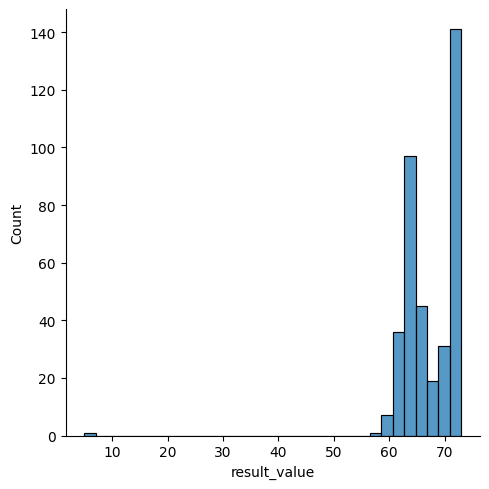

In [20]:
sns.displot(height['result_value'])

In [21]:
height.sort_values(['result_value'])

,subject_id,chartdate,seq_num,result_name,result_value
1844,10012853,2175-04-05,1,Height (Inches),5.0
2883,10002428,2154-10-18,1,Height (Inches),58.0
2885,10002428,2155-08-12,1,Height (Inches),59.0
2884,10002428,2158-09-13,1,Height (Inches),59.0
1203,10000032,2180-05-07,1,Height (Inches),60.0
...,...,...,...,...,...
778,10014354,2147-09-16,1,Height (Inches),73.0
775,10014354,2147-06-04,1,Height (Inches),73.0
776,10014354,2150-05-01,1,Height (Inches),73.0
2721,10022880,2176-05-04,1,Height (Inches),73.0


In [22]:
# let's see if this patient has other recorded height measurements
height[height['subject_id']==10012853].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value
1844,10012853,2175-04-05,1,Height (Inches),5.0
1846,10012853,2176-06-07,1,Height (Inches),64.0
1847,10012853,2177-01-05,1,Height (Inches),64.0
1845,10012853,2178-11-04,1,Height (Inches),64.0


In [23]:
height['std'] = height.groupby('subject_id')['result_value'].transform(np.std, ddof=0)

/tmp/ipython-input-368505687.py:1: FutureWarning: The provided callable <function std at 0x7a8bc4d98ae0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  height['std'] = height.groupby('subject_id')['result_value'].transform(np.std, ddof=0)


In [24]:
height.sort_values('std', ascending = False)[['subject_id', 'std']].drop_duplicates().head(10)

,subject_id,std
1845,10012853,25.547749
1095,10005909,2.724312
461,10019917,1.000000
2720,10022880,0.942809
300,10001725,0.862706
0,10011398,0.750000
1265,10037928,0.745356
2729,10004457,0.731247
2884,10002428,0.707107
524,10005348,0.596212


We can clearly see the one 'concerning' patient has a much higher standard deviation of their height measurements compared to other patients.

Let's take a look at patient with the second highest standard deviation

In [25]:
height[height['subject_id']==10005909].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value,std
1094,10005909,2144-10-29,1,Height (Inches),65.0,2.724312
1102,10005909,2144-11-15,1,Height (Inches),72.5,2.724312
1095,10005909,2144-12-10,1,Height (Inches),70.0,2.724312
1096,10005909,2145-01-03,1,Height (Inches),70.0,2.724312


### Another Example of Data Cleaning (Weight)

In [30]:
weight.head()

,subject_id,chartdate,seq_num,result_name,result_value
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136
5,10011398,2147-06-25,1,Weight (Lbs),139


**Review variable types**

It looks like `result_value` is a continuous variable. Let's make sure that Python also has recognized it as such.

In [31]:
# check variable data types
weight.dtypes

,0
subject_id,int64
chartdate,object
seq_num,int64
result_name,object
result_value,object


In [32]:
weight['result_value'] = pd.to_numeric(weight['result_value'])

In [33]:
# check variable data types
weight.dtypes

,0
subject_id,int64
chartdate,object
seq_num,int64
result_name,object
result_value,float64


In [34]:
weight['result_value'].describe()

,result_value
count,941.000000
mean,173.202763
std,44.009522
min,88.000000
25%,147.300000
50%,169.310000
75%,185.000000
max,296.000000


**Distribution of weight values**

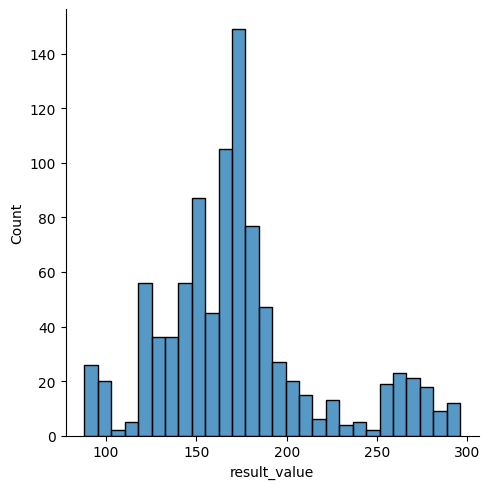

In [35]:
sns.displot(weight['result_value'])

**Investigate the standard deviation in the measurements of patients with multiple observations**

In [36]:
weight['std'] = weight.groupby('subject_id')['result_value'].transform(np.std, ddof=0)# ddof = 0 indicates that std for patients with one measurement will be displayed as 0 rather than NaN

/tmp/ipython-input-2567597466.py:1: FutureWarning: The provided callable <function std at 0x7a8bc4d98ae0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  weight['std'] = weight.groupby('subject_id')['result_value'].transform(np.std, ddof=0)# ddof = 0 indicates that std for patients with one measurement will be displayed as 0 rather than NaN


In [37]:
weight.sort_values('std', ascending = False)[['subject_id', 'std']].drop_duplicates().head(5)

,subject_id,std
177,10019385,58.385000
640,10021487,22.758934
1976,10019003,19.732249
1159,10039708,19.442869
2707,10040025,16.104849


In [38]:
weight[weight['subject_id']==10019385].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value,std
179,10019385,2180-02-15,1,Weight (Lbs),214.07,58.385
177,10019385,2180-03-04,1,Weight (Lbs),97.30,58.385


In [39]:
weight['result_value'].describe()

,result_value
count,941.000000
mean,173.202763
std,44.009522
min,88.000000
25%,147.300000
50%,169.310000
75%,185.000000
max,296.000000


Review a second patient with high standard deviation

In [40]:
weight[weight['subject_id']==10021487].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value,std
644,10021487,2117-01-14,1,Weight (Lbs),264.0,22.758934
643,10021487,2117-01-19,1,Weight (Lbs),254.0,22.758934
641,10021487,2117-02-10,1,Weight (Lbs),227.0,22.758934
638,10021487,2117-05-05,1,Weight (Lbs),204.0,22.758934
635,10021487,2117-06-16,1,Weight (Lbs),193.0,22.758934
656,10021487,2117-07-07,1,Weight (Lbs),196.6,22.758934
636,10021487,2117-08-18,1,Weight (Lbs),199.0,22.758934
637,10021487,2117-08-18,2,Weight (Lbs),199.0,22.758934
639,10021487,2117-09-09,1,Weight (Lbs),208.0,22.758934
657,10021487,2117-12-03,1,Weight (Lbs),210.1,22.758934


### Evaluating Unit Conversions

Another clinical variable that often needs cleaning are laboratory test measurements.

In MIMIC we can use the `labevents` and `d_labitems` tables to work with laboratory data.

Importantly, `d_labitems` links to the `labevents` table.

The `d_labitems` provides the definitions (or names) or the specific labs via the `itemid`.

In [41]:
labevents.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN


In [42]:
d_labitems.head()

,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas


### Example Data Cleaning (Laboratory Tests)

1. We can merge `d_labitems` and `labevents` by shared identifiers (we'll review this in the next section on merging tables)

2. We can search for specific labs of interest via the `label` column

3. We can also filter with specific `itemid` numbers if we know which correspond to labs of interest

First, let's try and see whether we can find the `itemid` for potassium

In [43]:
d_labitems[d_labitems['label'].str.contains('potassium', case = False, na=False)]

,itemid,label,fluid,category
20,52452,"Potassium, Whole Blood",Blood,Blood Gas
39,50822,"Potassium, Whole Blood",Blood,Blood Gas
56,52046,"Potassium, Urine",Urine,Blood Gas
59,50833,Potassium,Other Body Fluid,Blood Gas
218,52610,Potassium,Blood,Chemistry
308,50971,Potassium,Blood,Chemistry
490,51064,"Potassium, Stool",Stool,Chemistry
520,51097,"Potassium, Urine",Urine,Chemistry
636,50847,"Potassium, Ascites",Ascites,Chemistry
684,51057,"Potassium, Pleural",Pleural,Chemistry


In [44]:
potassium = labevents[labevents['itemid']==50971]
potassium

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
21,172088,10014354,29600294.0,43195817,50971,NaN,2148-08-16 00:00:00,2148-08-16 01:47:00,5.2,5.2,mEq/L,3.3,5.1,abnormal,ROUTINE,NaN
81,172597,10014354,26486158.0,78241917,50971,NaN,2148-08-24 00:00:00,2148-08-24 01:34:00,4.4,4.4,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
109,408883,10035631,29462354.0,7964528,50971,NaN,2112-09-24 00:00:00,2112-09-24 01:17:00,4.2,4.2,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
155,336034,10029484,NaN,79775396,50971,NaN,2160-11-08 00:00:00,2160-11-08 00:33:00,4.5,4.5,mEq/L,3.3,5.1,NaN,STAT,NaN
173,411486,10035631,20385771.0,88649212,50971,NaN,2112-12-16 00:00:00,2112-12-16 02:03:00,3.8,3.8,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107595,418158,10035631,29276678.0,2091476,50971,NaN,2116-03-05 18:59:00,2116-03-05 19:39:00,3.7,3.7,mEq/L,3.3,5.1,NaN,STAT,NaN
107605,408782,10035631,29462354.0,48589180,50971,NaN,2112-09-21 22:59:00,2112-09-22 01:11:00,3.8,3.8,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
107638,255520,10021487,28998349.0,52829826,50971,NaN,2116-12-22 04:59:00,2116-12-22 06:08:00,4.2,4.2,mEq/L,3.3,5.1,NaN,STAT,NaN
107663,473242,10040025,27876215.0,29795328,50971,NaN,2147-11-14 04:59:00,2147-11-14 06:18:00,3.9,3.9,mEq/L,3.3,5.1,NaN,STAT,NaN


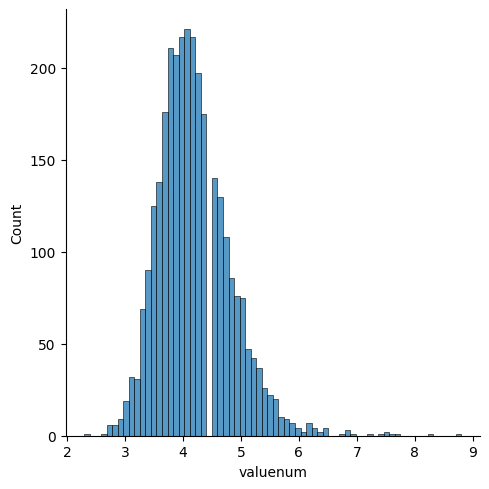

In [45]:
sns.displot(potassium['valuenum'])

# Introduction to Machine Learning with scikit-learn

First, we will load in our machine learning functions from scikit-learn

In [81]:
# load in our machine learning functions from scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score, auc, average_precision_score, precision_recall_curve, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [82]:
os.getcwd()

'/content/drive/MyDrive/4주차강의'

In this dataset, we will train a machine learning model to predict mortality using 4,000 unique patient records

In [83]:
train = pd.read_csv("data_a.csv.gz")
train

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,...,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
1,132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,...,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
2,132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,...,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
3,132543,7,1,9,575,0,68.0,1.0,180.3,84.6,...,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
4,132545,17,2,4,918,0,88.0,0.0,NaN,NaN,...,NaN,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665,19,7,10,336,0,70.0,0.0,NaN,87.0,...,152.0,NaN,NaN,17.5,NaN,7.39,23.0,1200.0,0.0,6.0
3996,142667,8,2,3,-1,0,25.0,1.0,NaN,166.4,...,NaN,NaN,NaN,3.0,166.4,NaN,NaN,NaN,NaN,NaN
3997,142670,8,5,11,-1,0,44.0,1.0,NaN,109.0,...,113.0,NaN,NaN,10.6,109.0,7.41,80.0,2580.0,1.0,15.0
3998,142671,22,10,8,7,1,37.0,1.0,NaN,87.4,...,145.0,NaN,NaN,11.5,87.4,7.34,82.0,2585.0,1.0,15.0


In [84]:
train.isnull().sum().sort_values(ascending = False)

,0
TroponinI_last,3795
TroponinI_first,3795
Cholesterol_first,3695
Cholesterol_last,3695
TroponinT_last,3137
...,...
Length_of_stay,0
SAPS-I,0
SICU,0
recordid,0


Let's create a separate dataframe to tally the number of missing values and plot the proportion of missing values

<Axes: >

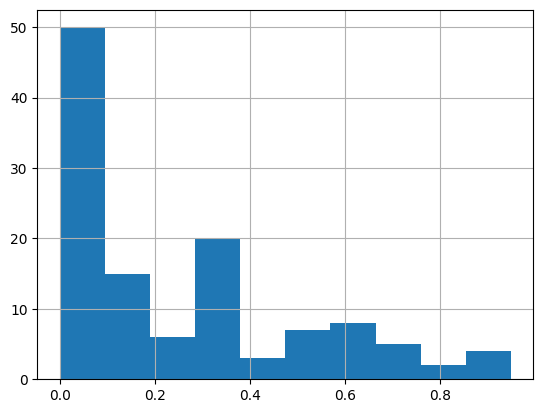

In [85]:
# calculate the proportion of missingness
num_missing = train.isnull().sum()
num_missing = num_missing/len(train)

num_missing.hist()

**Determine which features to keep in our model**

We can see that there are many variables that are largely incomplete. For our purposes, let's first only keep those variables which have <= 25% missing

In [86]:
vars_low_missing_rate = num_missing[num_missing <= 0.25].index.tolist()
len(vars_low_missing_rate)

71

Using the list of columns with a low missing rate, we can subset our `train` data to only include these columns

In [87]:
# keep columns with a low missing rate
X_vars = train[vars_low_missing_rate]

X_vars

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Weight,CCU,...,HCO3_last,HCT_last,K_last,Mg_last,Na_last,PaCO2_last,PaO2_last,Platelets_last,WBC_last,pH_last
0,132539,6,1,5,-1,0,54.0,0.0,NaN,0,...,28.0,30.3,4.0,1.9,136.0,NaN,NaN,185.0,9.4,NaN
1,132540,16,8,8,-1,0,76.0,1.0,76.0,0,...,24.0,29.4,3.5,1.9,135.0,46.0,140.0,135.0,13.3,7.37
2,132541,21,11,19,-1,0,44.0,0.0,56.7,0,...,25.0,29.4,3.7,1.7,138.0,37.0,173.0,113.0,6.2,7.47
3,132543,7,1,9,575,0,68.0,1.0,84.6,0,...,28.0,36.3,3.8,1.9,137.0,NaN,NaN,284.0,7.9,NaN
4,132545,17,2,4,918,0,88.0,0.0,NaN,0,...,20.0,30.9,4.1,1.6,139.0,NaN,NaN,97.0,4.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665,19,7,10,336,0,70.0,0.0,87.0,0,...,22.0,30.3,3.9,2.0,136.0,42.0,123.0,218.0,17.5,7.39
3996,142667,8,2,3,-1,0,25.0,1.0,166.4,0,...,28.0,31.9,3.4,1.5,142.0,NaN,NaN,118.0,3.0,NaN
3997,142670,8,5,11,-1,0,44.0,1.0,109.0,0,...,25.0,37.8,3.9,2.2,142.0,44.0,127.0,229.0,10.6,7.41
3998,142671,22,10,8,7,1,37.0,1.0,87.4,0,...,21.0,27.1,5.0,3.1,144.0,44.0,190.0,314.0,11.5,7.34


We can further reduce the number of variables by only choosing the first lab or vital measurements

In [88]:
X_first = X_vars.filter(regex='_first$')# keeps columns with the word 'first'
X_first.columns

Index(['GCS_first', 'Glucose_first', 'HR_first', 'NIDiasABP_first',
       'NIMAP_first', 'NISysABP_first', 'Temp_first', 'BUN_first',
       'Creatinine_first', 'HCO3_first', 'HCT_first', 'K_first', 'Mg_first',
       'Na_first', 'PaCO2_first', 'PaO2_first', 'Platelets_first', 'WBC_first',
       'pH_first'],
      dtype='object')

We should also consider keeping demographic (`Age`, `Gender`) and baseline information like `Weight` or intensive care unit admitted (`CCU`, `CSRU`, `SICU`)

In [89]:
X_baseline = X_vars[['Age', 'Gender', 'Weight', 'CCU', 'CSRU', 'SICU']]

Combine maintained set of features

In [91]:
X_train = pd.merge(X_baseline,
                   X_first,
                   left_index=True,
                   right_index=True)

In [92]:
X_train.head()

,Age,Gender,Weight,CCU,CSRU,SICU,GCS_first,Glucose_first,HR_first,NIDiasABP_first,...,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first
0,54.0,0.0,NaN,0,0,1,15.0,205.0,73.0,65.0,...,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN
1,76.0,1.0,76.0,0,1,0,3.0,105.0,88.0,38.0,...,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45
2,44.0,0.0,56.7,0,0,0,7.0,141.0,100.0,84.0,...,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51
3,68.0,1.0,84.6,0,0,0,15.0,129.0,79.0,63.0,...,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN
4,88.0,0.0,NaN,0,0,0,15.0,113.0,93.0,41.0,...,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN


Review number of missing variables once more on the 'cleaner' dataset

In [93]:
X_train.isnull().sum().sort_values()

,0
Age,0
CCU,0
SICU,0
CSRU,0
Gender,3
HR_first,63
Creatinine_first,64
GCS_first,64
BUN_first,64
Temp_first,64


In [94]:
# we will drop the 3 patients without a gender
X_train = X_train.dropna(subset=['Gender'])

Create `y` dataframe that will only contain our outcome of interest (`in-hospital_death`):

- When `in-hospital_death`=1 - indicates the patient died in the hospital
- When `in-hospital_death`=0 - indicates the patient did not die in the hospital

In [ ]:
y = pd.merge(train['In-hospital_death'], X_train,
             left_index=True,
             right_index=True)
# select outcome of interest
y = y['In-hospital_death']
# rename y df
y_train = y.copy()
y_train

,In-hospital_death
0,0
1,0
2,0
3,0
4,0
...,...
3995,0
3996,0
3997,0
3998,1


Tally the number of patients meeting each outcome

In [ ]:
y_train.value_counts()

,count
In-hospital_death,
0,3444
1,553
